In [1]:
# Goal: Create word vectors from Game of Thrones dataset
# and analyze them to see semantic similarity

# STEP 0: Import Dependencies

# Semantic similarity is a metric defined over a set of documents or terms, 
# where the idea of distance between them is based on the likeness of their 
# meaning or semantic content as opposed to similarity which can be estimated 
# regarding their syntactical representation (e.g. their string format).

# this acts like a bridge between Python 2 and Python 3 and it allows us to use 
# the syntax of both Python versions
from __future__ import absolute_import, division, print_function

# for word encoding
import codecs

# way of running mutiple threads and having each thread running on different processor (concurrency)
import multiprocessing

# dealing with operating system, like reading a file
import os

# pretty printing, human readable
import pprint

# regular expressions
import re

# natural language toolkit
import nltk

# word 2 vec
import gensim.models.word2vec as w2v

# dimensionality reduction (For more, see Siraj Video)
import sklearn.manifold

# math
import numpy as np

# data analysis
import pandas as pd

# plotting 
import matplotlib.pyplot as plt

# visualization
import seaborn as sns

In [2]:
# STEP 1: Process our data
# clean data

nltk.download('punkt')       # pre-trained tokenizer
nltk.download('stopwords')   # words like and, the, an, a, of etc..

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\VenD\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\VenD\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
# get the full path of all text files of GOT data

base_path = 'C:\\Users\\VenD\\Downloads\\GOT\\data\\'
file_names = os.listdir(base_path)
file_names_with_absolute_path = [base_path + fn for fn in file_names]

In [4]:
file_names_with_absolute_path[0]

'C:\\Users\\VenD\\Downloads\\GOT\\data\\got1.txt'

In [5]:
corpus_raw = u""
for file_name_with_path in file_names_with_absolute_path:
    print("Reading '{0}'...".format(file_name_with_path))
    with codecs.open(file_name_with_path, "r", "utf-8") as file:
        corpus_raw += file.read()
    print("Corpus is now {0} characters long".format(len(corpus_raw)))
    print

Reading 'C:\Users\VenD\Downloads\GOT\data\got1.txt'...
Corpus is now 1770659 characters long
Reading 'C:\Users\VenD\Downloads\GOT\data\got2.txt'...
Corpus is now 4071041 characters long
Reading 'C:\Users\VenD\Downloads\GOT\data\got3.txt'...
Corpus is now 6391405 characters long
Reading 'C:\Users\VenD\Downloads\GOT\data\got4.txt'...
Corpus is now 8107945 characters long
Reading 'C:\Users\VenD\Downloads\GOT\data\got5.txt'...
Corpus is now 9719485 characters long


In [6]:
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')

In [7]:
raw_sentences = tokenizer.tokenize(corpus_raw)

In [8]:
# convert into list of words
# remove unncecssary, split into words, no hyphens
# list of words

def sentence_to_wordlist(raw_sentence):
    clean_sentence = re.sub("[^a-zA-Z]", " ", raw_sentence)
    words = clean_sentence.split()
    return words

In [9]:
# sentence where each word is tokenized
sentences = []
for raw_sentence in raw_sentences:
    if len(raw_sentence) > 0:
        sentences.append(sentence_to_wordlist(raw_sentence))

In [10]:
print(raw_sentences[26])
print(sentence_to_wordlist(raw_sentences[26]))

He leaned against the battlement, the sea crashing beneath him, the black stone rough beneath his fingers.
['He', 'leaned', 'against', 'the', 'battlement', 'the', 'sea', 'crashing', 'beneath', 'him', 'the', 'black', 'stone', 'rough', 'beneath', 'his', 'fingers']


In [11]:
token_count = sum([len(sentence) for sentence in sentences])
print("The book corpus contains {0:,} tokens".format(token_count))

The book corpus contains 1,818,103 tokens


In [12]:
# ONCE we have word vectors

# STEP 3: Build Model

# 3 main tasks that vectors help with
# DISTANCE, SIMILARITY, RANKING

# Dimensionality of the resulting word vector
# more dimensions, more computationally expensive to train
# but also more accurate
# more dimensions = more generalized
num_features = 300

# Minimum word count threshold
min_word_count = 3

# Number of threads to run in parallel
# more workers, faster we train
num_workers = multiprocessing.cpu_count()

# Context window length
# 0 - 1e-5 is good for this
context_size = 7

# Downsampling setting for frequent words
downsampling = 1e-3

# Seed for the RNG(Random Number Generator), to make the results reproducible
# deterministic, good for debugging
seed = 1

In [13]:
thrones2vec = w2v.Word2Vec(
    sg=1,
    seed=seed,
    workers=num_workers,
    size=num_features,
    min_count=min_word_count,
    window=context_size,
    sample=downsampling
)

C:\Users\VenD\Anaconda3\lib\site-packages\gensim\models\base_any2vec.py:743: UserWarning: C extension not loaded, training will be slow. Install a C compiler and reinstall gensim for fast training.
  "C extension not loaded, training will be slow. "


In [14]:
thrones2vec.build_vocab(sentences)

In [15]:
print("Word2Vec vocabulary length: ", len(thrones2vec.wv.vocab))

Word2Vec vocabulary length:  17277


In [16]:
thrones2vec.train(sentences, total_examples=thrones2vec.corpus_count, epochs=1)

(1404382, 1818103)

In [19]:
# save the trained model
thrones2vec.save('C:\\Users\\VenD\\Downloads\\GOT\\model\\thrones2vec.w2v')

In [20]:
# load the pre-trained model
thrones2vec = w2v.Word2Vec.load('C:\\Users\\VenD\\Downloads\\GOT\\model\\thrones2vec.w2v')

In [21]:
# compress the word vectors to 2-D space and plot them
tsne = sklearn.manifold.TSNE(n_components=2, random_state=0)

In [27]:
all_word_vectors_matrix = thrones2vec.syn1neg

C:\Users\VenD\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `syn1neg` (Attribute will be removed in 4.0.0, use self.trainables.syn1neg instead).
  """Entry point for launching an IPython kernel.


In [28]:
_word_vectors_matrix_2d = tsne.fit_transform(all_word_vectors_matrix)

In [41]:
points = pd.DataFrame(
    [
        (word, coords[0], coords[1])
        for word, coords in [
            (word, _word_vectors_matrix_2d[thrones2vec.wv.vocab[word].index]) 
            for word in thrones2vec.wv.vocab
        ]
    ],
    columns = ['word', 'x', 'y']
)

In [45]:
points.head(10)

,word,x,y
0,This,-56.198654,-22.678133
1,edition,-2.025304,64.313622
2,the,-56.892639,-11.826502
3,complete,8.806727,33.827621
4,of,-67.799324,-0.562777
5,original,21.333099,51.871754
6,hardcover,33.254547,38.917313
7,ONE,22.537352,53.389874
8,A,-55.902596,-11.950974
9,OF,75.898323,13.218846


In [46]:
sns.set_context('poster')

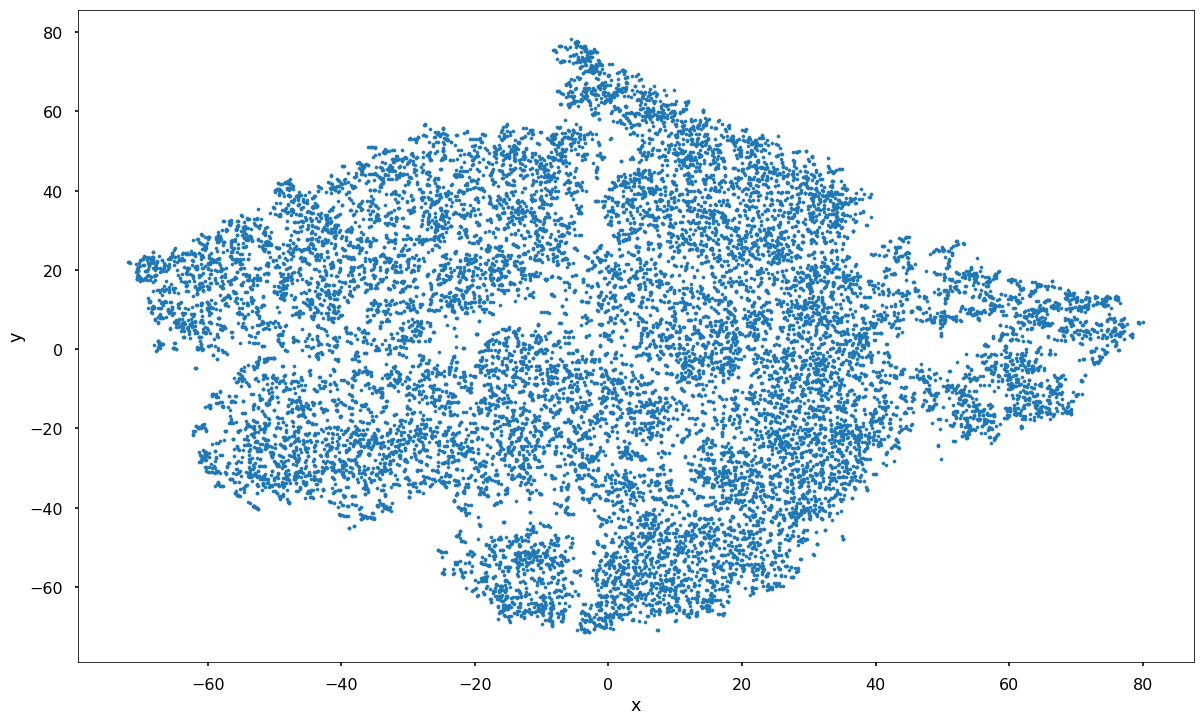

In [47]:
points.plot.scatter("x", "y", s=10, figsize=(20, 12))

In [90]:
def plot_region(x_bounds, y_bounds):
    bounded_region = points[
                (points.x >= x_bounds[0]) &
                (points.x <= x_bounds[1]) &
                (points.y >= y_bounds[0]) &
                (points.y <= y_bounds[1])
    ]
    
    ax = bounded_region.plot.scatter("x", "y", s=35, figsize=(10, 8))
    for i, point in bounded_region.iterrows():
        ax.text(point.x + 0.005, point.y + 0.005, point.word, fontsize=8)

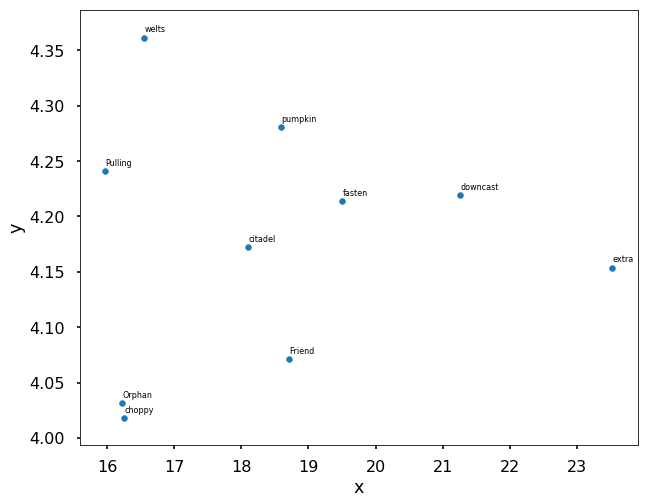

In [91]:
plot_region(x_bounds=(15, 25), y_bounds=(4.0, 4.5))

In [92]:
thrones2vec.most_similar("Stark")

C:\Users\VenD\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('Eddard', 0.9565814137458801),
 ('Arryn', 0.9533834457397461),
 ('Greyjoy', 0.9410203099250793),
 ('Renly', 0.938853919506073),
 ('Prince', 0.9351508617401123),
 ('Rhaegar', 0.9337440729141235),
 ('Joffrey', 0.9336349368095398),
 ('Tully', 0.9305182099342346),
 ('Aerys', 0.9229874610900879),
 ('Hoster', 0.9222842454910278)]

In [94]:
thrones2vec.most_similar('Arya')

C:\Users\VenD\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('Sansa', 0.9692503213882446),
 ('Bran', 0.9496420621871948),
 ('Brienne', 0.9480828046798706),
 ('Asha', 0.9278863072395325),
 ('Sam', 0.922933042049408),
 ('Cersei', 0.9214673042297363),
 ('Davos', 0.9190084338188171),
 ('Catelyn', 0.9166505336761475),
 ('Gilly', 0.9097610712051392),
 ('Theon', 0.9092691540718079)]

In [95]:
thrones2vec.most_similar('Daenerys')

C:\Users\VenD\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
  """Entry point for launching an IPython kernel.


[('Myrcella', 0.9761084914207458),
 ('Uncle', 0.9714770317077637),
 ('claim', 0.9698252081871033),
 ('rule', 0.9696239233016968),
 ('married', 0.9696092009544373),
 ('Thoros', 0.9691577553749084),
 ('Varys', 0.9675281643867493),
 ('Blackfish', 0.9674458503723145),
 ('Kingslayer', 0.9665724039077759),
 ('Val', 0.9660701751708984)]

In [105]:
def nearest_similarity_cosmul(start1, end1, end2):
    similarities = thrones2vec.wv.most_similar_cosmul(
        positive = [end2, start1],
        negative = [end1]
    )
    
    start2 = similarities[0][0]
    print(f"{start1} is related to {end1}, as {start2} is related to {end2}")

In [114]:
nearest_similarity_cosmul("Stark", "Winterfell", "Riverrun")
nearest_similarity_cosmul("Arya", "Sansa", "Jon")

Stark is related to Winterfell, as Prince is related to Riverrun
Arya is related to Sansa, as Sam is related to Jon
